In [8]:
import numpy as np
from scipy.stats import linregress
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns
import json

In [4]:
path = "results-uniform_N_100_K_50_k_20"
regret_Flooding = np.load(path + "/regret_Flooding.npz")
regret_FwA = np.load(path + "/regret_FwA.npz")
vary_ps = np.load("vary_ps.npz")

regret_Flooding_mean = np.array(regret_Flooding['regret_Flooding_mean'])
regret_Flooding_std = np.array(regret_Flooding['regret_Flooding_std'].flatten())
regret_FwA_mean = np.array(regret_FwA['regret_FwA_mean'])
regret_FwA_std = np.array(regret_FwA['regret_FwA_std'].flatten())
er_ps = np.array(vary_ps['er_ps'].flatten())
deltas_original = np.array(vary_ps['deltas'])
Thetas = np.array(vary_ps['Thetas'])
Thetas_FwA = np.array(vary_ps['Thetas_FwA'])

regret_gap = (regret_Flooding_mean - regret_FwA_mean).flatten()

In [20]:
N = 100
K = 50
k = 20
base_path = f"results-uniform_N_{N}_K_{K}_k_{k}"
tmp = np.load(f"../{base_path}/means.npz")
tmp = tmp['tmp']
reward_avgs = {a: tmp[a] for a in range(K)}
total_arm_set = list(range(K))
with open(f"../{base_path}/arm_sets_uniform.json", "r") as f:
    arm_sets = json.load(f)

# compute some stuff first
Deltas = np.zeros((K, 100))
for v in range(N):
    arm_set_v = arm_sets[v]
    for a in arm_set_v:
        Deltas[a][v] = max([reward_avgs[a_] for a_ in arm_set_v]) - reward_avgs[a]

# tilde{Delta]_a as in Yang et al., INFOCOM 2022
Deltas_tilde = []
for a in range(K):
    try:
        Deltas_tilde.append(min(Deltas[a][np.nonzero(Deltas[a])[0]]))
    except:
        Deltas_tilde.append(0)

deltas_Flooding, deltas_FwA = [], []
for i in range(len(er_ps)):
    tmp, tmpp = 0, 0
    for a in range(K):
        if Deltas_tilde[a] > 0:
            tmp += Thetas[i][a] / Deltas_tilde[a]
            tmpp += Thetas_FwA[i][a] / Deltas_tilde[a]
    deltas_Flooding.append(tmp)
    deltas_FwA.append(tmpp)

deltas_Flooding = np.array(deltas_Flooding)
deltas_FwA = np.array(deltas_FwA)

0.9439039683017291 1.400129557019371e-07 0.013899889031811372


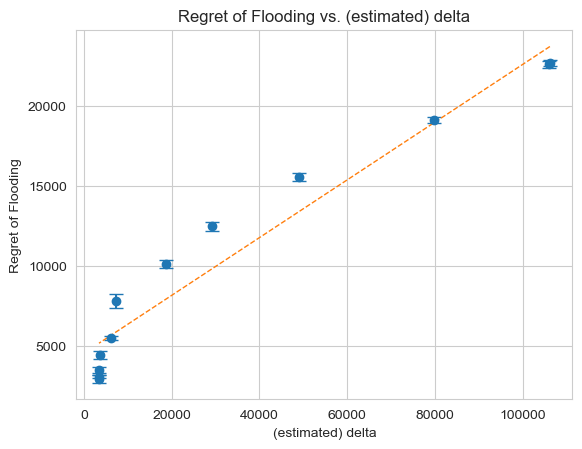

In [23]:
slope, intercept, r, p, stderr = linregress(deltas_Flooding, regret_Flooding_mean.flatten())
print(r**2, p, stderr)

with sns.axes_style("whitegrid"):
    plt.errorbar(deltas_Flooding, regret_Flooding_mean.flatten(), yerr=regret_Flooding_std, fmt='o', capsize=5)
    plt.plot(deltas_Flooding, slope*deltas_Flooding+intercept, linestyle='--', linewidth=1)
    
plt.title("Regret of Flooding vs. (estimated) delta")
plt.xlabel("(estimated) delta")
plt.ylabel("Regret of Flooding")
plt.savefig("delta_regret_Flooding.pdf", dpi=1200, bbox_inches='tight')
plt.show()

0.9813274053250963 5.630287574787167e-10 0.008433510129941259


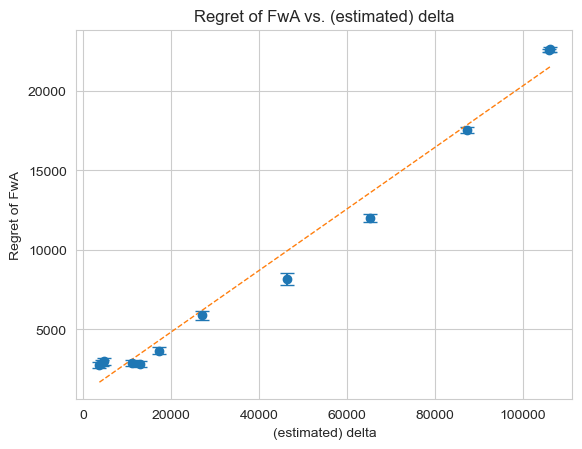

In [24]:
slope, intercept, r, p, stderr = linregress(deltas_FwA, regret_FwA_mean.flatten())
print(r**2, p, stderr)

with sns.axes_style("whitegrid"):
    plt.errorbar(deltas_FwA, regret_FwA_mean.flatten(), yerr=regret_FwA_std, fmt='o', capsize=5)
    plt.plot(deltas_FwA, slope*deltas_FwA+intercept, linestyle='--', linewidth=1)
    
plt.title("Regret of FwA vs. (estimated) delta")
plt.xlabel("(estimated) delta")
plt.ylabel("Regret of FwA")
plt.savefig("delta_regret_FwA.pdf", dpi=1200, bbox_inches='tight')
plt.show()

In [37]:
idx = np.argsort(deltas_original)

deltas = deltas_original[idx]
regret_gap = regret_gap[idx]
regret_gap_conf = [2.306*sqrt((9*(regret_Flooding_std[i]**2 + regret_FwA_std[i]**2)) / 18) * sqrt(1/5) for i in idx]

0.7847208361820732 0.00012567813486226111 0.042396771490489364


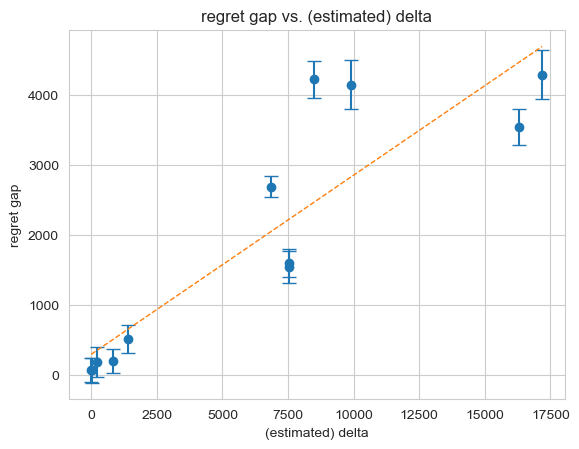

In [38]:
#find line of best fit
slope, intercept, r, p, stderr = linregress(deltas, regret_gap)
print(r**2, p, stderr)

# plotting
with sns.axes_style("whitegrid"):
    plt.errorbar(deltas, regret_gap, yerr=regret_gap_conf, fmt='o', capsize=5, label="regret gap")
    
    plt.plot(deltas, slope*deltas+intercept, linestyle='--', linewidth=1)
    
plt.title("regret gap vs. (estimated) delta")
plt.xlabel("(estimated) delta")
plt.ylabel("regret gap")
plt.savefig("delta_regretgap.pdf", dpi=1200, bbox_inches='tight')
plt.show()
# plt.close()

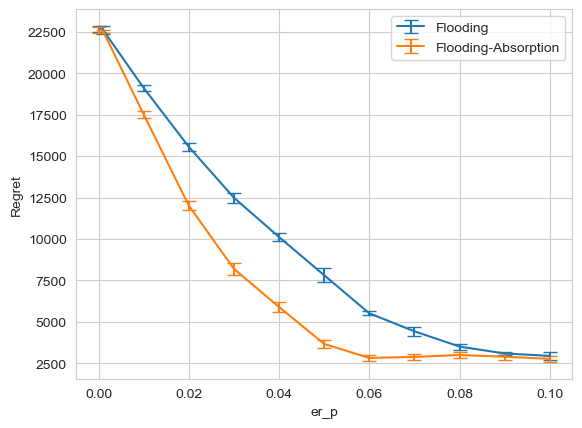

In [23]:
with sns.axes_style("whitegrid"):
    plt.errorbar(er_ps, regret_Flooding_mean.flatten(), yerr=regret_Flooding_std, label="Flooding", capsize=5)
    plt.errorbar(er_ps, regret_FwA_mean.flatten(), yerr=regret_FwA_std, label="Flooding-Absorption", capsize=5)
    plt.xlabel("er_p")
    plt.ylabel("Regret")
    plt.legend()
    plt.savefig(f"regret_pvary.pdf")

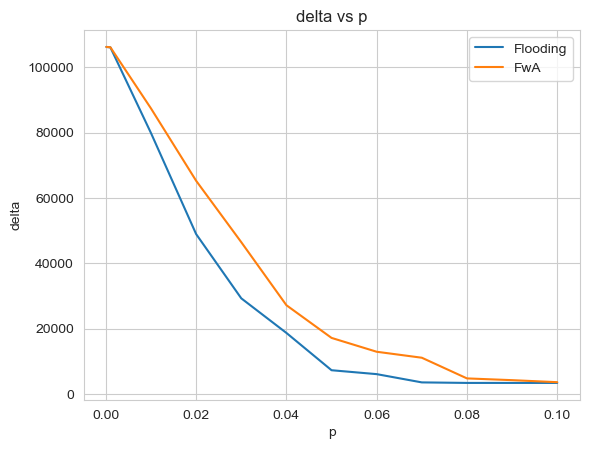

In [27]:
with sns.axes_style("whitegrid"):
    plt.plot(er_ps, deltas_Flooding, label="Flooding")
    plt.plot(er_ps, deltas_FwA, label="FwA")
    # plt.legend(["ER", "BA", "SBM"])
    plt.title(f"delta vs p")
    plt.xlabel("p")
    plt.ylabel("delta")
    plt.legend()
    plt.savefig(f"delta_pvary.pdf", dpi=500)